In [1]:
import numpy as np
from util import c_corners_within_radius as corners_within_radius
from util import c_ten_corners
from util import c_get_corner_crd
from util import c_distr_charge_one_atom

In [2]:
grid_spacing = np.array([0.5,0.5,0.5])
origin_crd = np.array([0.,0.,0.])
grid_counts = np.array([50,50,50])

In [3]:
grid_x = np.linspace(
        origin_crd[0],
        origin_crd[0] + ((grid_counts[0]-1) * grid_spacing[0]),
        num=grid_counts[0]
    )
grid_y = np.linspace(
    origin_crd[1],
    origin_crd[1] + ((grid_counts[1] - 1) * grid_spacing[1]),
    num=grid_counts[1]
)
grid_z = np.linspace(
    origin_crd[2],
    origin_crd[2] + ((grid_counts[2] - 1) * grid_spacing[2]),
    num=grid_counts[2]
)

i_max = grid_x.shape[0]
j_max = grid_y.shape[0]
k_max = grid_z.shape[0]

In [4]:
grid_tmp = np.empty([i_max, j_max, k_max], dtype=float)
atom_coordinate = np.array([i_max/2,j_max/2,k_max/2])*grid_spacing
uper_most_corner = np.array([i_max,j_max,k_max])
uper_most_corner_crd = uper_most_corner*grid_spacing
    
lj_diameter = 1.2
exponent = 1
charge = 3.24999852

dx2 = (atom_coordinate[0] - grid_x)**2
dy2 = (atom_coordinate[1] - grid_y)**2
dz2 = (atom_coordinate[2] - grid_z)**2

corners = corners_within_radius(atom_coordinate, lj_diameter, origin_crd, uper_most_corner_crd,
                                    uper_most_corner, grid_spacing, grid_x, grid_y, grid_z, grid_counts)
for i in range(i_max):
    dx_tmp = dx2[i]
    for j in range(j_max):
        dy_tmp = dy2[j]
        for k in range(k_max):

            d = dx_tmp + dy_tmp + dz2[k]
            # d = d - lj_diameter
            # d = d**exponent
            # grid_tmp[i,j,k] = charge / d
            # norm_charge = charge / grid_tmp.size
            sigma = .93333
            exp = np.exp(-(d-lj_diameter)**2/(2*(sigma**2)))
            pdf = charge*(1/np.sqrt(2*np.pi*sigma**2))*exp
            # pdf = pdf/grid_tmp.size
            if d != 0:
                # grid_tmp[i,j,k] = norm_charge / d
                grid_tmp[i,j,k] = pdf
            else:
                grid_tmp[i,j,k] = pdf
lj_radius = lj_diameter
corners = corners_within_radius(atom_coordinate, lj_radius, origin_crd, uper_most_corner_crd,
                                    uper_most_corner, grid_spacing, grid_x, grid_y, grid_z, grid_counts)
# print(grid_tmp[corners].sum())
print(grid_tmp.sum())
for i, j, k in corners:
    grid_tmp[i,j,k] = 0

164.3310675105338


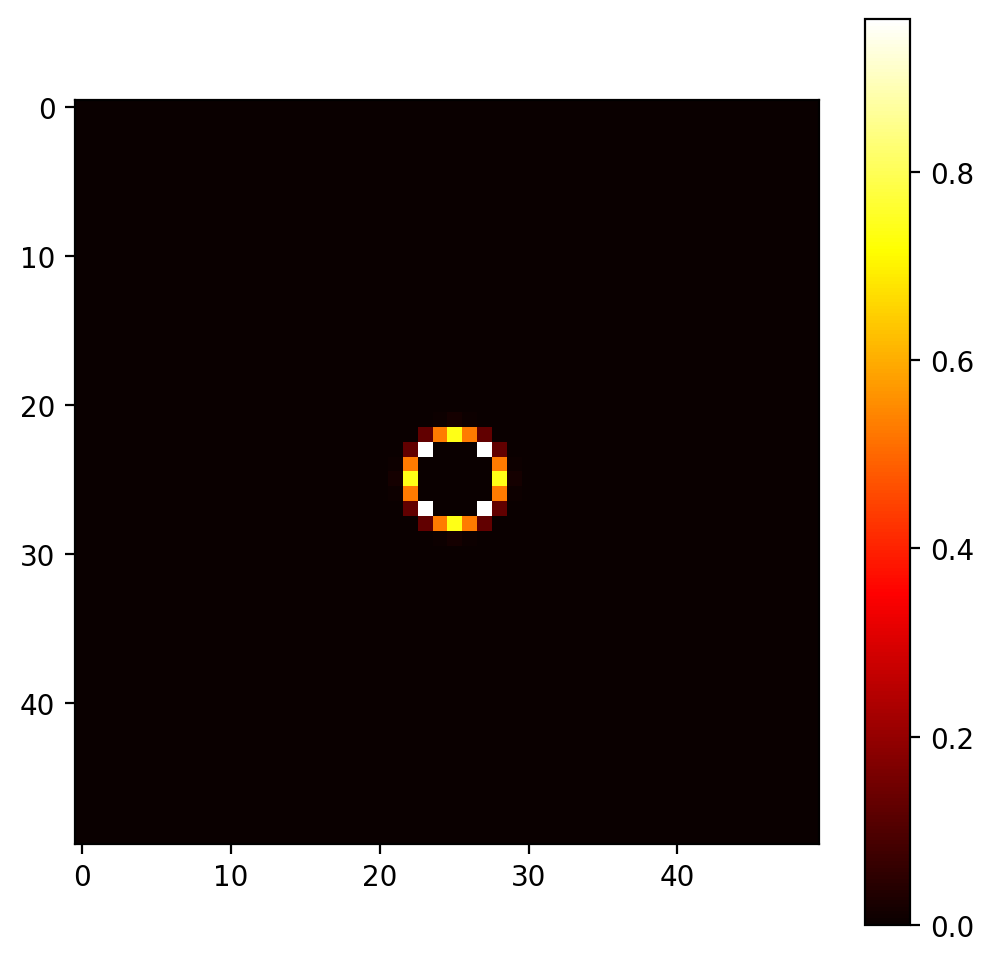

In [5]:
import matplotlib.pyplot as plt

# grid_tmp[grid_tmp < 0.1] = 0.
fig = plt.figure(figsize=(6, 6), dpi=200)
# ax = fig.add_subplot(projection='3d')

# ax.view_init(30, 60)
# ax.scatter(grid_x_r, grid_y_r, grid_z_r, c=grid_tmp)
# plt.scatter(grid_x_r, grid_z_r, c=grid_tmp, marker='.', vmin=1, vmax=2.16666568)
plt.imshow(grid_tmp[:,:,25], cmap='hot', interpolation='nearest')
plt.colorbar()

In [46]:
grid_x_r = np.tile(grid_x, (1,grid_counts[1],grid_counts[2]))
# grid_x_r = np.tile(grid_x_r, (1,grid_counts[2]))
# grid_y_r = np.tile(grid_y, (1,grid_counts[0]*grid_counts[2]))
# grid_y_r = np.repeat(grid_y, grid_counts[0]*grid_counts[2])
grid_z_r = np.repeat(grid_z, grid_counts[0]*grid_counts[1])
grid_y_r = np.tile(grid_y, (1,grid_counts[1],grid_counts[2]))
# grid_z_r = np.tile(grid_z, (1,grid_counts[1],grid_counts[2]))

In [73]:
grid_x_r.shape

(1, 50, 2500)

In [ ]:
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

In [19]:
grid_tmp.max()

2.16666568

In [6]:
six_corner_shifts = []
for i in [-1, 1]:
    six_corner_shifts.append(np.array([i,0,0], dtype=int))
    six_corner_shifts.append(np.array([0,i,0], dtype=int))
    six_corner_shifts.append(np.array([0,0,i], dtype=int))

six_corner_shifts = np.array(six_corner_shifts, dtype=int)
eight_corner_shifts = np.array([np.array([i,j,k], dtype=int) for i in range(2) for j in range(2) for k in range(2)])

b_vector = np.zeros([10], dtype=float)
a_matrix = np.zeros([10,10], dtype=float)

In [132]:

    ten_corners = c_ten_corners(atom_coordinate, origin_crd, uper_most_corner_crd, uper_most_corner,
                                    grid_spacing, eight_corner_shifts, six_corner_shifts, grid_x, grid_y, grid_z)
    b_vector[0] = charge
    a_matrix[0,:] = 1.0

    delta_vectors = []
    for corner in ten_corners:
        corner_crd = c_get_corner_crd(corner, grid_x, grid_y, grid_z)
        delta_vectors.append(corner_crd - atom_coordinate)

    for j in range(10):
        a_matrix[1][j] = delta_vectors[j][0]
        a_matrix[2][j] = delta_vectors[j][1]
        a_matrix[3][j] = delta_vectors[j][2]

    row = 3
    for i in range(3):
        for j in range(i, 3):
            row += 1
            for k in range(10):
                a_matrix[row][k] = delta_vectors[k][i] * delta_vectors[k][j]

    distributed_charges = np.linalg.solve(a_matrix, b_vector)

In [17]:
grid = np.zeros([i_max, j_max, k_max], dtype=float)
ten_corners, distributed_charges = c_distr_charge_one_atom( atom_coordinate, charge,
                                                        origin_crd, uper_most_corner_crd,
                                                        uper_most_corner, grid_spacing,
                                                        eight_corner_shifts, six_corner_shifts,
                                                        grid_x, grid_y, grid_z)
for i in range(len(ten_corners)):
    l, m, n = ten_corners[i]
    # below is effectively grid[l, m, n] += distributed_charges[i] for complex nums
    grid[l, m, n] += distributed_charges[i]

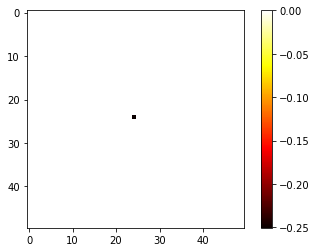

In [31]:
plt.imshow(grid[:,:,25], cmap='hot', interpolation='nearest')
plt.colorbar()

In [24]:
grid.max()
np.where(grid == grid.max())

(array([24]), array([24]), array([24]))

In [26]:
print(b_vector)

[array([23, 23, 24]), array([23, 24, 23]), array([23, 24, 24]), array([24, 23, 23]), array([24, 23, 24]), array([24, 24, 23]), array([24, 24, 24]), array([25, 24, 24]), array([24, 25, 24]), array([24, 24, 25])]


In [29]:
print(distributed_charges)

[ 0.11791378  0.11791378  0.132653    0.11791378  0.132653    0.132653
  3.24999852 -0.25056678 -0.25056678 -0.25056678]


In [40]:
from bpmfwfft.grids import LigGrid

In [ ]:
LigGrid.